# <center> STAT598: Homework 2 Solutions </center>
<center> Winter 2023 </center>


In [ ]:
# Download Data
import numpy as np
import torch
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy
import time

import matplotlib.pyplot as plt 
%matplotlib inline 

# Fix the random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(1)

# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8 of shape (n, 28, 28)
y_train = train_dataset.targets.long() # torch tensor of type Long of shape (n,)
test_dataset = FashionMNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets.long()

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32. Shape: (n, 28, 28)
X_train = X_train.view(-1, 784)  # Shape: (n, 784)
mean, std = X_train.mean(axis=0), X_train.std(axis=0)  # Shape: (784,)
# Normalize: add a small number to avoid divide by zero
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6) # Shape: (n, 784)

X_test = X_test.float()  # Shape: (n', 28, 28)
X_test = X_test.view(-1, 784)  # Shape: (n', 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)  # Shape: (n', 784)

n_class = np.unique(y_train).shape[0]  # We have K=10 classes numbered (0, 1, ..., 9)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


In [ ]:
# MLP set-up
# Some utility functions to compute the objective and the accuracy

def mlp(X, ws, bs):
    hidden = X # Shape: (n, d_0)
    for w, b in zip(ws[:-1], bs[:-1]):
        hidden = torch.matmul(hidden, w) + b[None, :]  # Shape: (n, d_{j-1}) * (d_{j-1}, d_j) = (n, d_j)
        hidden = torch.nn.functional.relu(hidden)
    return torch.matmul(hidden, ws[-1]) + bs[-1][None, :]

def compute_objective(ws, bs, X, y, reg_param):
    """ Compute the multinomial logistic loss. 
        ws is a list of tensors of consistent shapes,
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)  # Shape: (n, K)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return (
        cross_entropy(input=score, target=y, reduction='mean') 
        + 0.5 * reg_param * sum([torch.norm(w)**2 for w in ws])
    )

@torch.no_grad()
def compute_accuracy(ws, bs, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)  # shape: (n, K`)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(ws, bs, reg_param, verbose=False):
    train_loss = compute_objective(ws, bs, X_train, y_train, reg_param)
    test_loss = compute_objective(ws, bs, X_test, y_test, reg_param)
    train_accuracy = compute_accuracy(ws, bs, X_train, y_train)
    test_accuracy = compute_accuracy(ws, bs, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

def sgd_one_pass_mlp(ws, bs, X, y, reg_param, learning_rate, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    for i in range(num_examples):
        idx = np.random.choice(X.shape[0])
        # compute the objective. 
        # Note: This function requires X to be of shape (n,d). In this case, n=1 
        objective = compute_objective(ws, bs, X[idx:idx+1], y[idx:idx+1], reg_param) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        all_parameters = [*ws, *bs]
        gradients = torch.autograd.grad(outputs=objective, inputs=all_parameters)
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (var, g) in zip(all_parameters, gradients):
                var -= learning_rate * g
    return ws, bs

In [ ]:
# Use this to find the learning rate (divergent)
learning_rate = 0.03
reg_param = 1e-3

hidden_size = 16
ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]

_ = compute_logs(ws, bs, reg_param, verbose=True)


ws, bs = sgd_one_pass_mlp(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

Train Loss = 2.303, Train Accuracy = 0.145, Test Loss = 2.303, Test Accuracy = 0.156
1.4610237946776452
1.945945460461476
1.8835108237519715
1.5894047141138925
1.8457658810003548
2.148103175435085
2.0807528140018703
3.7164796965461595
4.730476029277998
15.596430368256973
18.991428158228533
58.589572959782785
89.73715152739673
157.4221836014501
342.0565379466415
703.0584052510649
1598.6518713980277
3201.4593225368226
4709.44736473771
10215.701295085011
22404.24208160788
39472.515409528314
50858.97630739354
81913.32904646712
111046.43177038
187257.41832695756
200523.99803833727
379371.6346733814
702117.3054981304
833103.218479138
2784526.11595824
5752505.202077955
7010725.645873423
20657918.69444524
24019571.965658884
31974520.6552649
85451638.18212037
109598017.540035
201569881.53750357
255717929.03339913
512309285.0941307
662165941.0494779
2033982260.1759787
4656586344.2243395
14299048577.080439
21959320643.339787
38846179026.824165
57182826632.73834
102039651982.27014
147492083763.133

In [ ]:
# Train for 100 epochs
learning_rate = 5e-3
hidden_width = [8,16,32,128,512]
train_loss={}
test_loss={}
train_acc={}
test_acc={}
for h in hidden_width:
  logs = []
  hidden_size = h
  ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
  bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]
  logs.append(compute_logs(ws, bs, reg_param, verbose=True))
  for j in range(100):
      if j%10==0:
        print(h,j)
      ws, bs = sgd_one_pass_mlp(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=False)
      logs.append(compute_logs(ws, bs, reg_param, verbose=False))
  logs = np.asarray(logs)
  train_loss[hidden_size] = logs[:, 0]
  test_loss[hidden_size] = logs[:, 2]
  train_acc[hidden_size] = logs[:, 1]
  test_acc[hidden_size] = logs[:, 3]

Train Loss = 2.303, Train Accuracy = 0.037, Test Loss = 2.303, Test Accuracy = 0.036
8 0
8 10
8 20
8 30
8 40
8 50
8 60
8 70
8 80
8 90
Train Loss = 2.303, Train Accuracy = 0.119, Test Loss = 2.303, Test Accuracy = 0.123
16 0
16 10
16 20
16 30
16 40
16 50
16 60
16 70
16 80
16 90
Train Loss = 2.303, Train Accuracy = 0.064, Test Loss = 2.303, Test Accuracy = 0.069
32 0
32 10
32 20
32 30
32 40
32 50
32 60
32 70
32 80
32 90
Train Loss = 2.303, Train Accuracy = 0.184, Test Loss = 2.303, Test Accuracy = 0.186
128 0
128 10
128 20
128 30
128 40
128 50
128 60
128 70
128 80
128 90
Train Loss = 2.303, Train Accuracy = 0.100, Test Loss = 2.303, Test Accuracy = 0.106
512 0
512 10
512 20
512 30
512 40
512 50
512 60
512 70
512 80
512 90


Part 1: Graphing Results

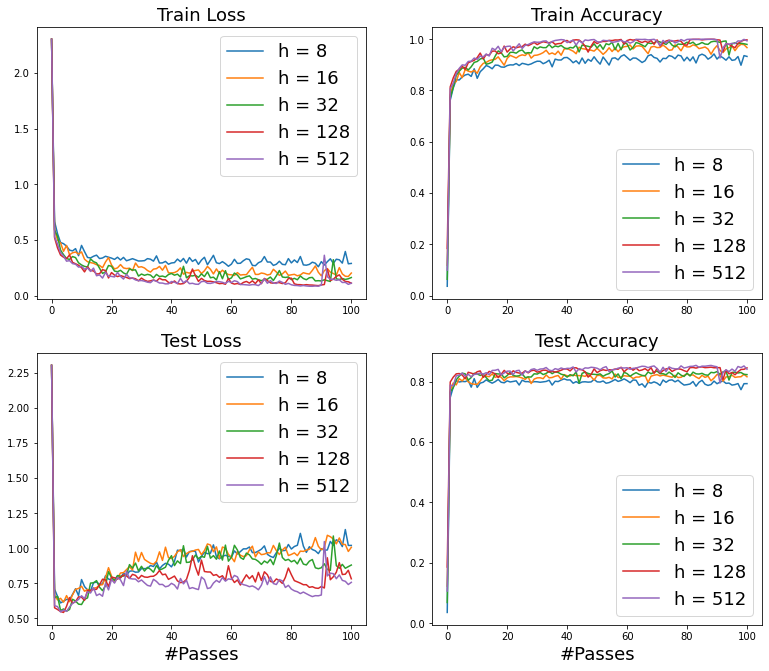

In [ ]:
hidden_sizes = [8,16,32,128,512]
f, ax = plt.subplots(2, 2, figsize=(13, 11))
for h in hidden_sizes:
  ax[0, 0].plot(train_loss[h], label=f'h = {h}')
  ax[1, 0].plot(test_loss[h], label=f'h = {h}')
  ax[0, 1].plot(train_acc[h], label=f'h = {h}')
  ax[1, 1].plot(test_acc[h], label=f'h = {h}')

ax[0, 0].set_title('Train Loss', fontsize=18)
ax[1, 0].set_title('Test Loss', fontsize=18)
ax[0, 1].set_title('Train Accuracy', fontsize=18)
ax[1, 1].set_title('Test Accuracy', fontsize=18)

ax[1, 0].set_xlabel('#Passes', fontsize=18)
ax[1, 1].set_xlabel('#Passes', fontsize=18)

ax[0, 0].legend(fontsize=18)
ax[1, 0].legend(fontsize=18)
ax[0, 1].legend(fontsize=18)
ax[1, 1].legend(fontsize=18)

Part 2: Width vs. Interpolate
Width 32 is the start of a near perfect training accueracy (.99).

In [ ]:
hidden_sizes = [8,16,32,128,512]
for h in hidden_sizes:
  print("Width: ",h, "Max Train Acc: ",train_acc[h].max())

Width:  8 Max Train Acc:  0.94233334
Width:  16 Max Train Acc:  0.9798333
Width:  32 Max Train Acc:  0.993
Width:  128 Max Train Acc:  0.9996667
Width:  512 Max Train Acc:  0.99983335


Text(0.5, 1.0, 'Minimum Epochs to Interpolation at Different Widths')

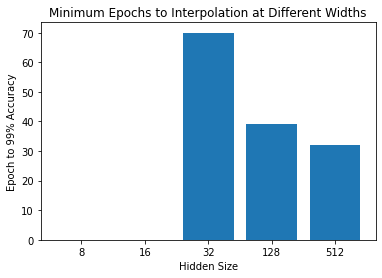

In [ ]:
min_epoch = [0,0,70,39,32]
h= ["8", "16","32","128","512"]
plt.bar(h, min_epoch)
plt.xlabel("Hidden Size")
plt.ylabel("Epoch to 99% Accuracy")
plt.title("Minimum Epochs to Interpolation at Different Widths")

# Probelm 2: Bonus


In [ ]:
h= [4, 16, 128, 2048]
d =[4e-2, 3e-2, 3e-2, 3e-2]
# Use this to find the learning rate (divergent)
learning_rate = 3e-2
reg_param = 1e-3

hidden_size = h[3]
ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]

_ = compute_logs(ws, bs, reg_param, verbose=True)


ws, bs = sgd_one_pass_mlp(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

In [ ]:
# Train for 100 epochs
#learning_rate = [n,n/2,n/4,n/8]
train_loss={}
test_loss={}
train_acc={}
test_acc={}
learning_rate = 3e-2
reg_param = 1e-3
for h in range(4):
  logs = []
  hidden_size = 8
  n=3e-2
  lr = n/2**h
  ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
  bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]
  logs.append(compute_logs(ws, bs, reg_param, verbose=True))
  for j in range(1):
      if j%10==0:
        print(h,j)
      ws, bs = sgd_one_pass_mlp(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=False)
      logs.append(compute_logs(ws, bs, reg_param, verbose=False))
  logs = np.asarray(logs)
  train_loss[h] = logs[:, 0]
  test_loss[h] = logs[:, 2]
  train_acc[h] = logs[:, 1]
  test_acc[h] = logs[:, 3]

Train Loss = 2.303, Train Accuracy = 0.083, Test Loss = 2.303, Test Accuracy = 0.092
0 0
Train Loss = 2.303, Train Accuracy = 0.044, Test Loss = 2.303, Test Accuracy = 0.045
1 0
Train Loss = 2.303, Train Accuracy = 0.048, Test Loss = 2.303, Test Accuracy = 0.054
2 0
Train Loss = 2.303, Train Accuracy = 0.150, Test Loss = 2.303, Test Accuracy = 0.155
3 0


Text(0.5, 1.0, 'Best Test Accuracy to Interpolation at Different Widths')

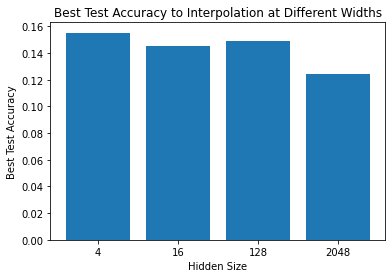

In [ ]:
#test_acc_8=test_acc
#test_acc_16=test_acc
#test_acc_128=test_acc
#test_acc_2048=test_acc
test_acc=test_acc_8[3][0],test_acc_16[3][0],test_acc_128[3][0],test_acc_2048[3][0]
h= ['4', '16', '128', '2048']

plt.bar(h, test_acc)
plt.xlabel("Hidden Size")
plt.ylabel("Best Test Accuracy")
plt.title("Best Test Accuracy to Interpolation at Different Widths")
